# CDK2 protein: Conformations Metadata
# Data load and preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [4]:
%run ./1_Helper_functions.ipynb

## Load the data
### Ensemble docking scores

In [5]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.12


### Protein conformations metadata

In [4]:
path_to_file = '../data/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json'
df_prot = pd.read_json(path_to_file)

#### Protein volume

In [5]:
# Volume using povme
# Get it manually to include SASA
df_pocket = pd.read_csv('../../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_RICCI_402/res_output.txt', sep='|', 
            skiprows=844, header=None, skipfooter=3, engine='python',
            names=['pdb_id', 'volumen', 'surf_area'], index_col=0)

# Include it to the final table
df_pocket.index = df_prot.index
# merge both
df_pocket = df_prot.merge(df_pocket, how='inner', left_index=True, right_index=True)

#### Apo or holo conformation
Only with respect to the defined pocket

In [6]:
df_pocket['Apo'] = ['holo' if i > 0 else 'apo' for i in df_pocket.NumLigs] 

# How many of each are there?
df_pocket['Apo'].value_counts()

holo    395
apo       7
Name: Apo, dtype: int64

#### If the protein is bound to other proteic entities 

In [7]:
df_pocket['Single Entity'] = ['bound' if i > 1 else 'single' for i in df_pocket.Entities] 

#### Fill Inhibitor mass column with 0s

In [8]:
df_pocket['Inhib_mass'] = pd.to_numeric(df_pocket['Inhib_mass']).fillna(0)

#### Fill Resolution values, if needed

In [9]:
df_pocket['Resolution'] = pd.to_numeric(df_pocket['Resolution']).fillna(0)

#### Get the performance measures and append them

In [10]:
# AUC ROC
metric_params = {'metric_name': 'roc_auc'}
roc_auc = PlotMetric(y, X_merged_dksc.to_dict('list'),
                decreasing=True).format_metric_results(rounded=5, **metric_params)

# Enrichment Factor Ra=12
metric_params = {'metric_name': 'ef', 'fraction': 0.12, 'method':'normalized'}
nef_012 = PlotMetric(y, X_merged_dksc.to_dict('list'),
                decreasing=True).format_metric_results(rounded=5, **metric_params)

# Merge all dataframes
df_merged = df_pocket.join([roc_auc, nef_012], how='inner')

### Keep and rename important columns

In [17]:
# Rename some columns
last_vars = ['Resolution', 'Inhib_mass', 'volumen', 'surf_area', 'Apo', 'Single Entity', 'ROC AUC', 'EF']
new_names = ['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. Surf. Area', 'Apo', 'Single Entity', 'AUC-ROC', 'NEF']
df_final = df_merged[last_vars].rename(columns=dict(zip(last_vars, new_names)))
df_final.columns

Index(['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. Surf. Area', 'Apo',
       'Single Entity', 'AUC-ROC', 'NEF'],
      dtype='object')

In [33]:
# Save the dataframe
@run_or_load
def save_df(filename, df):
    return df

# Save it
df_final = save_df(f'./TABLE_Confs_Features_and_performances_{prot_name}.pkl', df_final)

File saved: ./TABLE_Confs_Features_and_performances.pkl


,Resolution,Inhib. MW,Pk. Volume,Pk. Surf. Area,Apo,Single Entity,AUC-ROC,NEF
1aq1,2.00,440.0,887.0,628.0,holo,single,0.62262,0.24337
1b38,2.00,398.0,698.0,587.0,holo,single,0.59115,0.21205
1b39,2.10,398.0,672.0,559.0,holo,single,0.61789,0.27711
1buh,2.60,0.0,657.0,609.0,apo,bound,0.55508,0.17831
1ckp,2.05,214.0,747.0,510.0,holo,single,0.63232,0.32048
...,...,...,...,...,...,...,...,...
6q4g,0.98,258.0,683.0,499.0,holo,single,0.54921,0.20964
6q4h,1.00,274.0,733.0,516.0,holo,single,0.59664,0.23855
6q4i,1.11,234.0,630.0,529.0,holo,single,0.56800,0.22410
6q4j,1.05,218.0,680.0,579.0,holo,single,0.60731,0.24819


# Correlations

In [18]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

def calculate_pvalues(df, func=spearmanr):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(func(df[r], df[c])[1], 4)
    return pvalues

def corrfunc(x, y, func=spearmanr, **kws):
    r, _ = func(x, y)
    ax = plt.gca()
    ax.annotate(r"$\rho$ = {:.2f}".format(r), fontsize=14,
                xy=(.1, .9), xycoords=ax.transAxes)

In [19]:
df_final.columns

Index(['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. Surf. Area', 'Apo',
       'Single Entity', 'AUC-ROC', 'NEF'],
      dtype='object')

In [24]:
display(df_final.corr(method='spearman'))
display(calculate_pvalues(df_final))

,Resolution,Inhib. MW,Pk. Volume,Pk. Surf. Area,AUC-ROC,NEF
Resolution,1.000000,0.107123,0.456019,0.193254,0.174428,-0.027653
Inhib. MW,0.107123,1.000000,0.299617,0.121486,0.376494,0.322069
Pk. Volume,0.456019,0.299617,1.000000,0.492225,0.196941,0.047071
Pk. Surf. Area,0.193254,0.121486,0.492225,1.000000,-0.118342,-0.207717
AUC-ROC,0.174428,0.376494,0.196941,-0.118342,1.000000,0.808929
NEF,-0.027653,0.322069,0.047071,-0.207717,0.808929,1.000000


,Resolution,Inhib. MW,Pk. Volume,Pk. Surf. Area,AUC-ROC,NEF
Resolution,0,0.0318,0,0.0001,0.0004,0.5804
Inhib. MW,0.0318,0,0,0.0148,0,0
Pk. Volume,0,0,0,0,0.0001,0.3465
Pk. Surf. Area,0.0001,0.0148,0,0,0.0176,0
AUC-ROC,0.0004,0,0.0001,0.0176,0,0
NEF,0.5804,0,0.3465,0,0,0


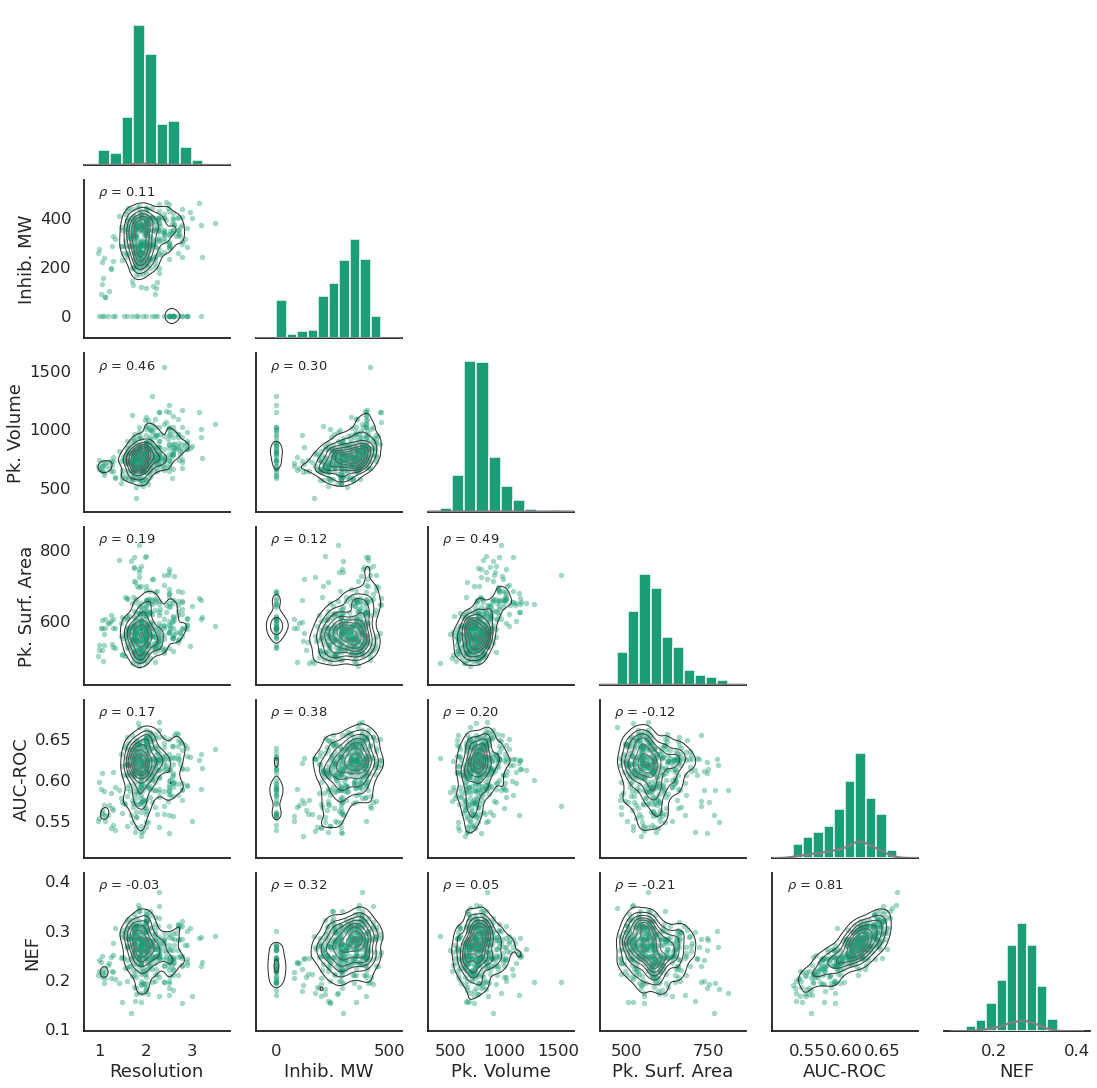

In [30]:
g = sns.pairplot(df_final, diag_kind="hist", corner=True,  
                 plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k', 'linewidth': 0})
g.map_lower(sns.kdeplot, levels=8, color=".5", linewidths=1)
g.map_diag(sns.kdeplot, color='.5')
g.map_lower(corrfunc)
plt.show()

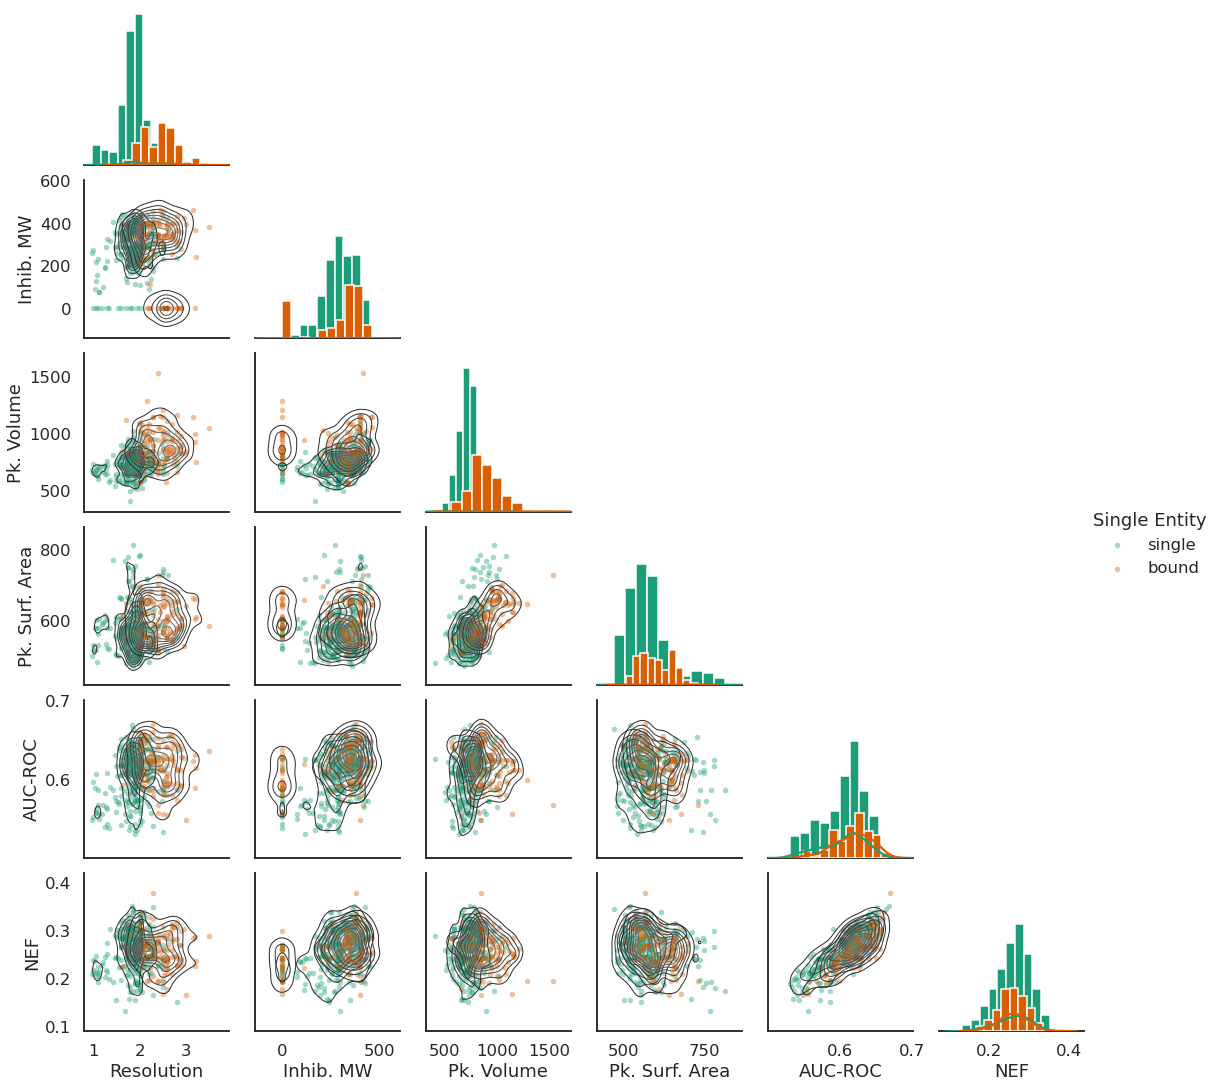

In [31]:
g = sns.pairplot(df_final, diag_kind="hist", corner=True, hue='Single Entity',
                 plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k', 'linewidth': 0})
g.map_lower(sns.kdeplot, levels=8, color=".5", linewidths=1)
g.map_diag(sns.kdeplot)
# g.map_lower(corrfunc)
plt.show()

In [1]:
# XX

<AxesSubplot:>

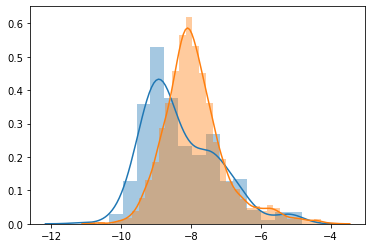

In [20]:
# Get the decoys 
actives = X_merged_dksc.loc[y.astype(bool)]
inactives = X_merged_dksc.loc[~y.astype(bool)]

# Get the means
m_act = actives.mean(axis=1)
m_inact = inactives.mean(axis=1)

hist = sns.distplot(m_act, 
                      label='Decoys/Inactives',hist_kws={'linewidth': 0}, norm_hist=True)
sns.distplot(m_inact, ax=hist, bins=35,
             label='Actives', hist_kws={'linewidth': 0}, norm_hist=True)

<AxesSubplot:>

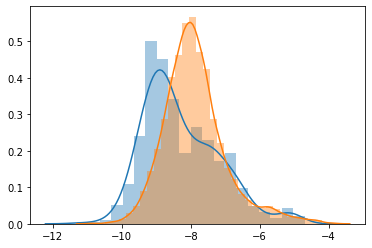

In [31]:
# Get the means
v_act = actives.quantile(q=[0.4, 0.6], axis=1)
v_inact = inactives.quantile(q=[0.4, 0.6], axis=1)

hist = sns.distplot(v_act, 
                      label='Decoys/Inactives',hist_kws={'linewidth': 0}, norm_hist=True)
sns.distplot(v_inact, ax=hist, bins=35,
             label='Actives', hist_kws={'linewidth': 0}, norm_hist=True)